## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_108.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(86593, 10)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20210501]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr14', 'alpha_kama', 'alpha_AI', 'alpha_083'],
      dtype='object')

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [4]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret 'alpha_atr14', 'alpha_kama', 'alpha_AI'
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 479/479 [00:32<00:00, 14.63it/s]


### Rescale AI Factor

In [5]:
def rescale_(data):
    # resize from -1 to 1
    feature = 'alpha_AI'
    data[feature] = data[feature] - data[feature].median()
    max_val = data[feature].median() + 3*data[feature].std()
    min_val = data[feature].median() - 3*data[feature].std()
    data[feature] = np.where(data[feature]>max_val, max_val, 
                           np.where(data[feature]<min_val, min_val, data[feature]))
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                             np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

# need to fix excuted in privious step
def zscore_AI(data):
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

#universe_z = universe.groupby('trade_date').apply(rescale_)
universe_z = universe.groupby('trade_date')[universe.columns].apply(zscore_AI)

0.05477959


<AxesSubplot:>

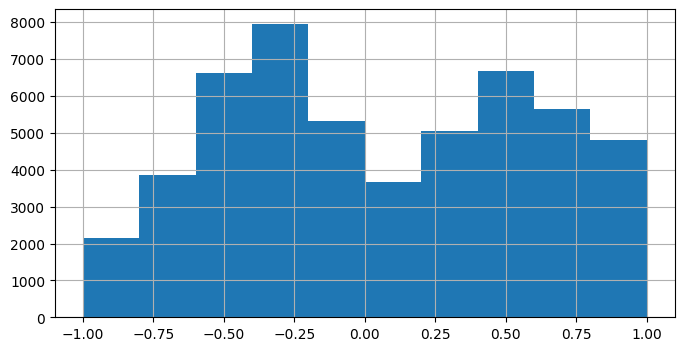

In [6]:
print(universe_z['alpha_AI'].mean())
universe_z['alpha_AI'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [7]:
## shif return 5 days
all_factors = universe_z.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date'])
print(universe.shape, all_factors.shape)

(51732, 10) (51732, 11)


In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr14    0.007195
alpha_kama    -0.009624
alpha_AI      -0.004518
alpha_083     -0.030816
dtype: float64

In [9]:
from scipy.stats import zscore
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

start_time = 20220501
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df['trade_date']>=start_time]
calendar = alpha_df.trade_date.unique() # int64

## only for positive estimate
for feature in alpha_field:
    alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 238/238 [00:05<00:00, 42.28it/s]


alpha_atr14    0.0
alpha_kama     0.0
alpha_083      0.0
alpha_AI       0.0
dtype: float64

#### Veiw Factor Returns

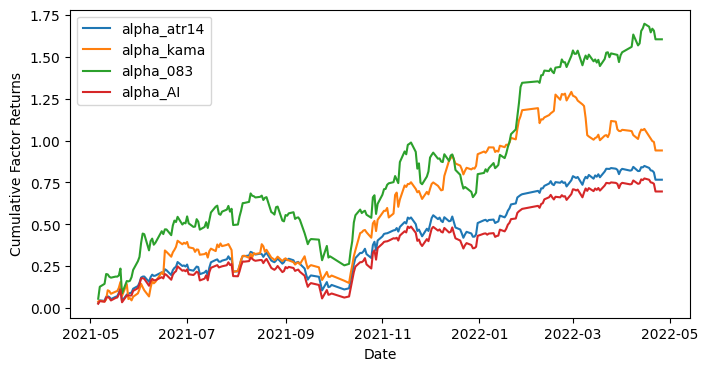

In [10]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [13]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=250):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [14]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    for col in returns_df.columns:
        returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 3
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector

def get_positive_returns(df):
    for col in df.columns:
        df[col] = np.where(df[col]<0, df[col], 0.)
    return df

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
returns_df = get_positive_returns(returns_df)
variance_i, B, risk_fr, residual_i = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 241
return date 20220505


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002462.SZ,002577.SZ,002605.SZ,...,688230.SH,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.065562,0.030993,0.025372,0.025804,0.024517,0.024722,0.023013,0.025604,0.026084,0.035237,...,0.025514,0.0,0.017741,0.037316,0.049271,0.024882,0.028051,0.036571,0.029836,0.035800
000756.SZ,0.030993,0.082796,0.020515,0.018991,0.018515,0.020455,0.017889,0.021022,0.020256,0.028112,...,0.018930,0.0,0.014120,0.030242,0.041445,0.019735,0.020829,0.027684,0.021731,0.029956
000915.SZ,0.025372,0.020515,0.072165,0.020455,0.017318,0.015768,0.015892,0.017073,0.018198,0.022982,...,0.019905,0.0,0.012853,0.025239,0.031125,0.017496,0.020407,0.029357,0.023137,0.023080
002322.SZ,0.025804,0.018991,0.020455,0.064915,0.026742,0.015950,0.022050,0.017977,0.025240,0.028796,...,0.031123,0.0,0.015673,0.028631,0.027865,0.021947,0.032983,0.042257,0.038492,0.021461
002362.SZ,0.024517,0.018515,0.017318,0.026742,0.043191,0.018036,0.022511,0.018051,0.025194,0.032371,...,0.026086,0.0,0.013331,0.028431,0.031531,0.020560,0.032265,0.031127,0.033945,0.022938


In [15]:
risk_fr.iloc[-1,:]

0   -0.094336
1   -0.006797
2   -0.002736
Name: 20220505, dtype: float64

In [16]:
h=np.array([1]*108) 
(np.dot(h, variance_i).dot(h.T))** 0.5

18.366793223902103

In [17]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:]]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 241
(25704, 3) (25704, 12)


### Calculate Risk Factor Returns

In [19]:
## calculate risk factor return module
def change_risk_B_col(B):
    new_colnames = ['risk_' + str(_) for _ in B.columns if 'risk_' not in str(_)]
    if len(new_colnames) == 0:
        return B
    B_columns_map = {}
    for i, col in enumerate(B.columns):
        B_columns_map[col] = new_colnames[i]
    B = B.rename(columns=B_columns_map)
    return B

tmp = all_factors.loc[all_factors['trade_date']==20220601].sort_values(by=['ts_code'])
B = change_risk_B_col(B)
B.index.name='ts_code'
tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
estimate_factor_returns(tmp, name='risk_')

risk_0   -0.258817
risk_1   -0.045498
risk_2    0.006135
dtype: float64

In [21]:
for dt in tqdm(calendar, desc='regression risk returns'):
    tmp = all_factors.loc[all_factors['trade_date']==dt].sort_values(by=['ts_code'])
    B = variance_all[dt][1]
    B = change_risk_B_col(B)
    B.index.name='ts_code'
    tmp = tmp.merge(B.reset_index(), on=['ts_code'], how='left')
    facotr_return = estimate_factor_returns(tmp, name='risk_')
    variance_all[dt][2]=facotr_return

#variance_all[calendar[-1]][2]

regression risk returns: 100%|████████████████| 238/238 [00:05<00:00, 47.55it/s]


risk_0    0.0
risk_1    0.0
risk_2    0.0
dtype: float64

### (Optional) Store Residual

In [ ]:
#universe = universe.merge(residual_df, on=['ts_code', 'trade_date'], how='left')
#universe = universe.rename(columns={'residual': 'alpha_resi'})
#universe = universe.loc[universe['trade_date']>=start_time]

In [ ]:
#universe['alpha_resi'].hist()

In [ ]:
# universe['alpha_resi'] = universe['alpha_resi'] * 1000
# universe.to_csv('AI_data/factors_AI_108_residual.csv')

### Combine Factors

In [251]:
#'alpha_atr14', 'alpha_kama', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['ts_code'])
#alpha_df['alpha_all'] = alpha_df['alpha_083']
alpha_df['alpha_all'] = 0.4 * alpha_df['alpha_atr14'] + .6 * alpha_df['alpha_083']             
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

0.9487994502474926 -0.9828309043124899


In [252]:
# for dt in alpha_df.trade_date.unique():
#     tmp = alpha_df.loc[alpha_df.trade_date==dt]
#     print(tmp.name)

### Backtest by Convex Optimization
- use `scipy.optimize.fmin_l_bfgs_b` top optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk rescale weights

In [253]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=.001): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + aversion * (np.dot(h, variance).dot(h.T)) ** 0.5 \
             + np.dot((h-h0)**2, Lambda) 
             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=.001):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + 0.5 * aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) 
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220601
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0, 20000)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal

55087.49894170445 29320.562886505268
45462.90207502149 47079.223016767995


<AxesSubplot:>

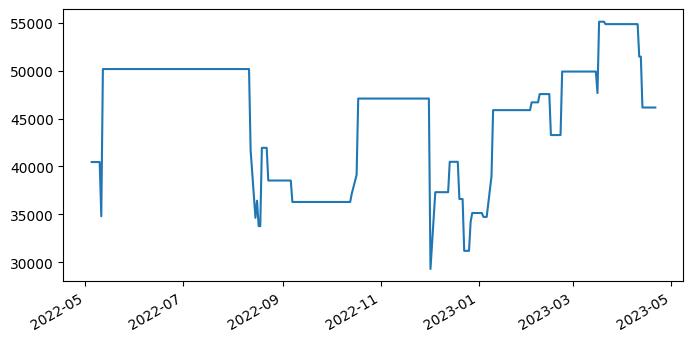

In [254]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [255]:
#for i in positions.keys():
#    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum())
#    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum())
    #positions[i]['h_opt'] = positions[i]['h_opt']/1500
    #positions[i]['h_privious'] = positions[i]['h_privious']/1500
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [256]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

55087.49894170445 29320.562886505268


46145.580584246425 (8, 13)


name  close   log-ret   h_privious        h_opt
date       ts_code                                                   
2023-04-21 002322.SZ  理工能科  10.52 -0.054567  7124.719310  7124.719310
           002462.SZ   嘉事堂  14.59 -0.015641  6036.638075  6036.638075
           002788.SZ  鹭燕医药   9.11 -0.012002  8725.412574  8725.412574
           300531.SZ   优博讯  14.07 -0.078565  3776.525275  3776.525275
           300639.SZ  凯普生物  16.84  0.001188  3554.263689  3554.263689
           603229.SH  奥翔药业  22.86  0.029747  5255.998282  5255.998282
           603368.SH  柳药集团  23.79  0.003790  8507.298978  8507.298978
           603386.SH  骏亚科技  11.74 -0.053888  3164.724401  3164.724401

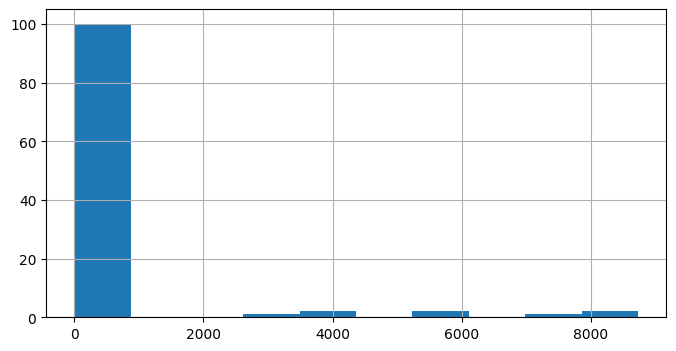

In [257]:
positions[20230421]['h_opt'].hist()
tmp = positions[20230421].loc[positions[20230421]['h_opt']>=1000]
print(positions[20230421].loc[positions[20230421]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['name', 'close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

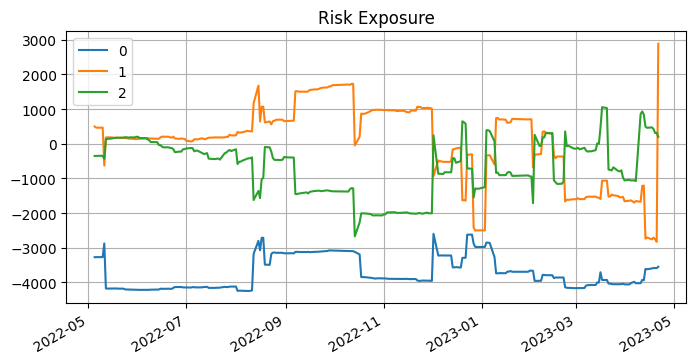

In [258]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

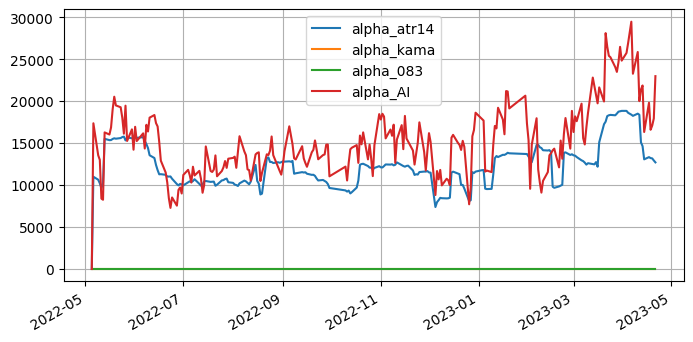

In [259]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[0.4, 0.0, 0.0, 0.6]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

2083.8857213529136 -18570.143666724864


<AxesSubplot:>

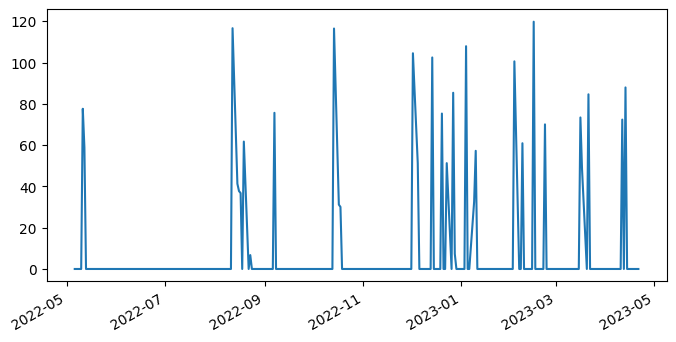

In [260]:
transaction_costs = []
retre_max = 0
Lambda = 3e-6
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    if min(tmp_change)<retre_max:
        retre_max = min(tmp_change)
    costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    transaction_costs.append(costs)
print(sum(transaction_costs),retre_max)
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Profit-and-Loss (PnL)

2023-04-17 00:00:00


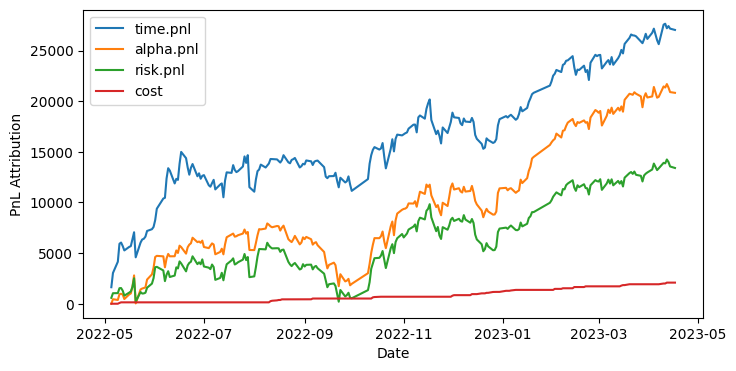

In [261]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()[:-4]
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr14', 'alpha_kama', 'alpha_083', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [262]:
attr['time.pnl'].sum()

27042.816282086562

In [177]:
attr['time.pnl'].cumsum().min()

514.2909938550147